<a href="https://colab.research.google.com/github/dbizzaro/NotebooksKRL/blob/main/MaxSAT_BNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Based on a project by Inês Jesus and Auriane Mahfouz, with modifications and explanations by Davide Bizzaro.

# Binarized Neural Networks



Binarized neural networks (BNNs) are neural network whose inputs, outputs and weights can only have values $1$ or $-1$.

As usual, given a training set $\{(x_i, y_i)\}_{i\in [n]}$, the goal is to learn an optimal combination of weights that maximize classification accuracy.


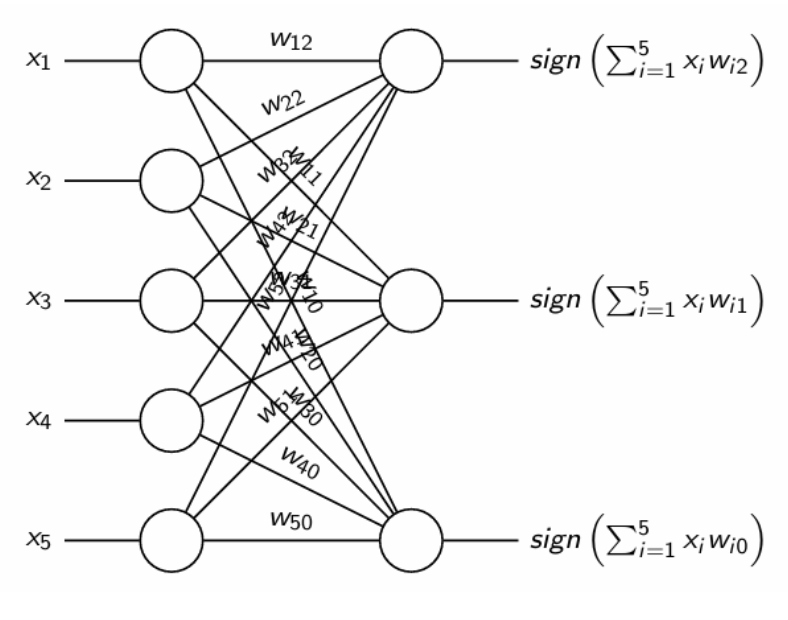



The activation function is the $sign$ function, so each neuron $j$ is computing

 $$sign(\sum_i x_i w_{ij}) = sign(XW_j)$$

This is nothing but the majority rule over the values $x_iw_{ij}$. In logical terms, $1$ corresponds to $True$ and $-1$ to $False$. Hence, $x_iw_{ij}$ corresponds to $x_i\equiv w_{ij}$ and the majority rule to $$``x_i \equiv w_{ij} \ \text{for at least more than half of the $i$'s''}$$

## Importing Libraries

In [1]:
! pip install python-sat

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 12.5 MB/s eta 0:00:00


In [2]:
import itertools
import time
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import pandas as pd
from pysat.formula import WCNF, CNF
from pysat.examples.rc2 import RC2
#from pysat.examples.fm import FM

## Generating the dataset

We consider $5$ input propositions and all their possible truth values, resulting in $32$ unique input vectors:

In [3]:
NUM_INPUT = 5
inputs = list(itertools.product([-1,1], repeat=NUM_INPUT))

In [4]:
for x in inputs:
  print(x)

(-1, -1, -1, -1, -1)
(-1, -1, -1, -1, 1)
(-1, -1, -1, 1, -1)
(-1, -1, -1, 1, 1)
(-1, -1, 1, -1, -1)
(-1, -1, 1, -1, 1)
(-1, -1, 1, 1, -1)
(-1, -1, 1, 1, 1)
(-1, 1, -1, -1, -1)
(-1, 1, -1, -1, 1)
(-1, 1, -1, 1, -1)
(-1, 1, -1, 1, 1)
(-1, 1, 1, -1, -1)
(-1, 1, 1, -1, 1)
(-1, 1, 1, 1, -1)
(-1, 1, 1, 1, 1)
(1, -1, -1, -1, -1)
(1, -1, -1, -1, 1)
(1, -1, -1, 1, -1)
(1, -1, -1, 1, 1)
(1, -1, 1, -1, -1)
(1, -1, 1, -1, 1)
(1, -1, 1, 1, -1)
(1, -1, 1, 1, 1)
(1, 1, -1, -1, -1)
(1, 1, -1, -1, 1)
(1, 1, -1, 1, -1)
(1, 1, -1, 1, 1)
(1, 1, 1, -1, -1)
(1, 1, 1, -1, 1)
(1, 1, 1, 1, -1)
(1, 1, 1, 1, 1)


We define $4$ different target functions, that the BNN will have to learn:



In [5]:
# Node function 1 to returns majority of the input nodes
def majority_function(x):
    return 1 if sum(x) > 0 else -1

# Node function 2 returns parity of positive nodes
def parity_function(x):
    count_ones = sum(1 for xi in x if xi == 1)
    return 1 if count_ones % 2 == 0 else -1

# Node function 3 returns if the first n or last n nodes are all positive
def first_or_last_n(x,n):
    first_n = sum([x[i] == 1 for i in range(n)]) == n
    last_n = sum([x[i] == 1 for i in range(-n,0)]) == n
    first_or_last = first_n or last_n
    return 1 if first_or_last else -1

# Node function 4 returns negation of input node i, i=0,...,4
def negation_input(x,i):
    neg_result = (x[i-1] == -1)
    return 1 if neg_result else -1

In [6]:
targets = [(majority_function(x),
            parity_function(x),
            first_or_last_n(x,2),
            negation_input(x,3))
            for x in inputs]

NUM_OUTPUT = len(targets[0])

Use 25% of the data as test set:

In [7]:
X_train, X_test, y_train, y_test = train_test_split(inputs,
                                                    targets,
                                                    test_size=0.25,
                                                    random_state=42)
print("training pairs:", len(X_train))
print("test pairs:", len(X_test))

training pairs: 24
test pairs: 8


## BNN encoding

Let us build the logical representation for a BNN with 3 hidden neurons.

In [8]:
NUM_HIDDEN = 3
layers = [NUM_INPUT, NUM_HIDDEN, NUM_OUTPUT]

We need to assign a different index to all input/hidden/output values (for each training sample), as well as to all the weights.

In [9]:
def neuron_index(t, n_layer, i):
    """
    t: training sample index
    n_layer: layer index (starting from 1)
    i: neuron index
    """
    cum_sum = np.sum(layers[0:n_layer-1]) * len(X_train) #offset to avoid the indexes for the nodes in previous layers
    return int(cum_sum + t * layers[n_layer-1] + i + 1)

def weight_index(n_layer, i, j):
    """
    n_layer: layer index (starting from 1)
    i: previous neuron index
    j: next neuron index
    """
    n_neurons = np.sum(layers) * len(X_train) #offset to avoid the indexes for the neurons
    cum_weight_sum = sum(x * y for x, y in zip(layers[:n_layer-1], layers[1:n_layer])) #offset to avoid the indexes for the weights between previous layers
    return int(n_neurons + cum_weight_sum + i + j * layers[n_layer-1] + 1)

Let us check!

In [10]:
#Check the indexes for the neurons' values
for n_layer in range(len(layers)):
  for t in range(len(X_train)):
    for i in range(layers[n_layer]):
      print(neuron_index(t,n_layer+1,i))

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


Thus, as an example, proposition 288 encode the last input value for the last input vector in the training set.

In [11]:
#Check the indexes for the weights
for n_layer in range(len(layers[:-1])):
  for j in range(layers[n_layer+1]):
    for i in range(layers[n_layer]):
        print(weight_index(n_layer+1,i,j))

289
290
291
292
293
294
295
296
297
298
299
300
301
302
303
304
305
306
307
308
309
310
311
312
313
314
315


Let us also encode an auxiliary proposition for each pair (sample, weight). This will be useful later.

In [12]:
def auxiliary_index(t, n_layer, i, j):
    """
    t: training sample index
    n_layer: layer index (starting from 1)
    i: neuron index
    j: next neuron index
    """
    n_neurons = np.sum(layers) * len(X_train) #offset for neurons
    n_weights = sum(x * y for x, y in zip(layers[:-1], layers[1:])) #offset for weights
    cum_weight_sum = len(X_train) * sum(x * y for x, y in zip(layers[:n_layer-1], layers[1:n_layer])) #offset for pairs with weights of previous layers
    return int(n_neurons + n_weights + cum_weight_sum + t * layers[n_layer-1]*layers[n_layer] + i + j * layers[n_layer-1] + 1)

In [13]:
#check the indexes for the auxiliary propositions
for n_layer in range(len(layers[:-1])):
  print('new layer')
  for t in range(len(X_train)):
    print('new t')
    for j in range(layers[n_layer+1]):
      #print('new j')
      for i in range(layers[n_layer]):
        print(auxiliary_index(t,n_layer+1,i,j))


new layer
new t
316
317
318
319
320
321
322
323
324
325
326
327
328
329
330
new t
331
332
333
334
335
336
337
338
339
340
341
342
343
344
345
new t
346
347
348
349
350
351
352
353
354
355
356
357
358
359
360
new t
361
362
363
364
365
366
367
368
369
370
371
372
373
374
375
new t
376
377
378
379
380
381
382
383
384
385
386
387
388
389
390
new t
391
392
393
394
395
396
397
398
399
400
401
402
403
404
405
new t
406
407
408
409
410
411
412
413
414
415
416
417
418
419
420
new t
421
422
423
424
425
426
427
428
429
430
431
432
433
434
435
new t
436
437
438
439
440
441
442
443
444
445
446
447
448
449
450
new t
451
452
453
454
455
456
457
458
459
460
461
462
463
464
465
new t
466
467
468
469
470
471
472
473
474
475
476
477
478
479
480
new t
481
482
483
484
485
486
487
488
489
490
491
492
493
494
495
new t
496
497
498
499
500
501
502
503
504
505
506
507
508
509
510
new t
511
512
513
514
515
516
517
518
519
520
521
522
523
524
525
new t
526
527
528
529
530
531
532
533
534
535
536
537
538
539
540


### Hard constraints

Time to write the constraints! We use a WCNF() object to store the hard and soft clauses.

In [14]:
wcnf = WCNF()

Encode the training set, by forcing the input propositions to agree with corresponding input value in the training set (for each pair (t,i)).


```
from X_train
t1 = 1,1,1,-1,-1
t2 = -1,-1,-1,1,1

node 1 for t1 is 1 --> hard clause x1 = 1
node 2 for t1 is 1 --> hard clause x2 = 1
node 3 for t1 is 1
node 4 for t1 is -1
node 5 for t1 is -1

node 1 for t2 is -1 --> hard clause x6 = -1
node 2 for t2 is -1
node 3 for t2 is -1
node 4 for t2 is 1
node 5 for t2 is 1

etc
```



In [15]:
for t in range(len(X_train)):
    for i in range(NUM_INPUT):
        if X_train[t][i] > 0:
            wcnf.append([neuron_index(t,1,i)])
        else:
            wcnf.append([-neuron_index(t,1,i)])

Now, we need to encode the neural activations with the majority rule over the truth values $x_{ti} \equiv w_{ij}$ for each training sample $t$, and nodes $i$ and  $j$ (on subsequent layers):

Let us fix the pair of adjacent layers and let $n$ be the number of nodes of the first one.
Node value $x_{tj}$ should be $True$ if there is a subset $S$ with $|S|>n/2$ of nodes in the previous layer such that $x_{ti} \equiv w_{ij}$ for all nodes $i\in S$. Viceversa, $x_{tj}$ should be $False$ if there is a subset $S$ with $|S|>n/2$ of nodes in the previous layer such that $\neg (x_{ti} \equiv w_{ij})$ for all nodes $i\in S$. In formulas:

$$\bigwedge_t  \left(\left( \bigvee_{|S|>n/2} \ \bigwedge_{i\in S} x_{ti} \equiv w_{ij}\right) \to x_{tj} \right)$$  

and

$$\bigwedge_t  \left(\left( \bigvee_{|S|>n/2} \ \bigwedge_{i\in S} \neg(x_{ti} \equiv w_{ij})\right) \to \neg x_{tj} \right)$$

These are the formulas forcing the node values to respect the neural network definition for each training sample.



We are not done yet, because we need to transform the previous formulas into CNF. Here is where we use the auxiliary propositions, for a Tseytin transformation: let  $$p_{tij} \equiv (x_{ti} \equiv w_{ij})$$
where $p_{tij}$'s are the auxiliary variables.

The CNF of $a \equiv (b \equiv c)$ is $$(a \vee b \vee c) \wedge (a \vee \neg b \vee \neg c) \wedge (\neg a \vee b \vee \neg c) \wedge (\neg a \vee \neg b \vee c) $$

Thus, to use the Tseytin transformation:, we need to enforce the following clauses:
$$\bigwedge_{t,i,j} (p_{tij} \vee x_{ti} \vee w_{ij}) \wedge (p_{tij} \vee \neg x_{ti} \vee \neg w_{ij}) \wedge (\neg p_{tij} \vee x_{ti} \vee \neg w_{ij}) \wedge (\neg p_{tij} \vee \neg x_{ti} \vee w_{ij})$$


In [16]:
for layer in range(1,len(layers)):
  for t in range(len(X_train)):
    for j in range(layers[layer]):
      for i in range(layers[layer-1]):
        wcnf.append([weight_index(layer,i,j), neuron_index(t,layer,i), auxiliary_index(t,layer,i,j)])
        wcnf.append([-weight_index(layer,i,j), -neuron_index(t,layer,i), auxiliary_index(t,layer,i,j)])
        wcnf.append([weight_index(layer,i,j), -neuron_index(t,layer,i), -auxiliary_index(t,layer,i,j)])
        wcnf.append([-weight_index(layer,i,j), neuron_index(t,layer,i), -auxiliary_index(t,layer,i,j)])


Now, we can substitute $p_{tij}$ for $x_{ti} \equiv w_{ij}$ in the previous formulas:

$$\bigwedge_t  \left(\left( \bigvee_{|S|>n/2} \ \bigwedge_{i\in S} p_{tij}\right) \to x_{tj} \right)$$  

and

$$\bigwedge_t  \left(\left( \bigvee_{|S|>n/2} \ \bigwedge_{i\in S} \neg p_{tij}\right) \to \neg x_{tj} \right)$$

whose CNFs are:

$$\bigwedge_t \ \bigwedge_{|S|>n/2} \  \bigvee_{i\in S} \  \neg p_{tij} \vee x_{tj}$$  

and

$$\bigwedge_t \ \bigwedge_{|S|>n/2} \  \bigvee_{i\in S} \ p_{tij} \vee \neg x_{tj}$$  

In [17]:
def add_layer_new(layer_n, wcnf_formula):
  n_prev_neurons = layers[layer_n-1]
  n_next_neurons = layers[layer_n]
  for t in range(len(X_train)):
    # add hard clauses for connection between neurons
    for j in range(n_next_neurons):
      neuron_next_x = neuron_index(t,layer_n+1,j)
      input_selection = itertools.combinations(range(n_prev_neurons), n_prev_neurons // 2 + 1)
      for subset in input_selection:
        wcnf_formula.append([-auxiliary_index(t,layer_n,i,j) for i in subset]+[neuron_next_x])
        wcnf_formula.append([auxiliary_index(t,layer_n,i,j) for i in subset]+[-neuron_next_x])
  return wcnf_formula

### Soft constraints

The soft constraints should force the maximum number of output neuron values to match the desired target value. So, for every train sample $t$ with targets $y_{tj}\in \{-1,1\}$, we add the weighted clause $(1: x_{tj})$ if $y_{tj}=1$ and the weighted clause $(1: \neg x_{tj})$ if $y_{tj}=-1$.

In [18]:
def add_output_layer(wcnf_formula):
  n_prev_neurons = layers[-2]
  for t in range(len(y_train)):
    for j in range(NUM_OUTPUT):
      y_clause = [neuron_index(t,len(layers),j)*y_train[t][j]]
      wcnf_formula.append(y_clause, weight = 1)
  return wcnf_formula

Use the previous functions to append the hard and soft clauses to wcnf:

In [19]:
start = time.time()
for i,layer in enumerate(layers):
  if i < len(layers)-1:
    # add hard clauses of connections between neurons
    wcnf = add_layer_new(i+1,wcnf)
  else:
    # add soft clauses for the output
    wcnf = add_output_layer(wcnf)
layers_clauses_time = time.time()-start #measure time to add all clauses

In [20]:
print("number of hard clauses:", len(wcnf.hard))
print("number of soft clauses:", len(wcnf.soft))
print("number of variables:", wcnf.nv)

number of hard clauses: 4728
number of soft clauses: 96
number of variables: 963


## Training and evaluation

We use RC2 solver from pysat as MaxSAT solver. Other solvers, like Fu and Malik are available (but may take longer).

In [21]:
wcnf_copy = wcnf.copy() #use a copy of the formulas, because the solver may change them
solver = RC2(wcnf_copy)

start = time.time()
model = solver.compute()
model_compute_time = time.time()-start #measure the computing time

In [22]:
solver.cost

12

It means $12$ errors among the $24 * 4$ training output values.

In [23]:
print(model)

[-1, 2, 3, -4, -5, -6, -7, -8, -9, -10, -11, -12, 13, -14, -15, 16, -17, -18, -19, -20, -21, -22, 23, -24, 25, -26, 27, 28, -29, 30, -31, 32, -33, 34, 35, 36, -37, 38, 39, 40, -41, -42, -43, -44, 45, -46, -47, -48, 49, -50, 51, 52, -53, 54, -55, -56, -57, -58, 59, 60, 61, -62, 63, -64, 65, 66, 67, -68, 69, 70, 71, -72, 73, 74, -75, 76, -77, -78, 79, -80, 81, 82, 83, 84, 85, 86, -87, 88, -89, -90, -91, -92, 93, 94, 95, -96, 97, -98, 99, -100, -101, 102, 103, 104, -105, 106, 107, 108, -109, -110, 111, -112, -113, 114, 115, -116, -117, 118, 119, -120, 121, -122, 123, 124, -125, 126, 127, -128, 129, 130, -131, -132, 133, -134, 135, 136, 137, 138, -139, 140, -141, -142, 143, 144, 145, -146, 147, 148, -149, -150, -151, 152, -153, -154, -155, 156, 157, 158, 159, -160, 161, -162, 163, 164, -165, -166, -167, -168, -169, 170, -171, 172, -173, 174, 175, 176, 177, -178, -179, -180, 181, 182, -183, 184, 185, -186, -187, 188, -189, 190, -191, 192, -193, 194, -195, -196, -197, 198, -199, -200, -201, 

In [24]:
#check the correctness of the auxiliary variables
for layer in range(1,len(layers)):
  for t in range(len(X_train)):
    for j in range(layers[layer]):
      for i in range(layers[layer-1]):
        w_ij = weight_index(layer,i,j)
        h_ti = neuron_index(t,layer,i)
        h_tj = neuron_index(t,layer+1,j)
        a_tij = auxiliary_index(t,layer,i,j)
        print(np.sign(model[w_ij-1]), np.sign(model[h_ti-1]), np.sign(model[h_tj-1]), np.sign(model[a_tij-1]), np.sign(model[a_tij-1])==np.sign(model[w_ij-1])*np.sign(model[h_ti-1]))

-1 -1 1 1 True
-1 1 1 -1 True
1 1 1 1 True
-1 -1 1 1 True
-1 -1 1 1 True
1 -1 -1 -1 True
1 1 -1 1 True
1 1 -1 1 True
1 -1 -1 -1 True
1 -1 -1 -1 True
-1 -1 1 1 True
-1 1 1 -1 True
1 1 1 1 True
-1 -1 1 1 True
1 -1 1 -1 True
-1 -1 1 1 True
-1 -1 1 1 True
1 -1 1 -1 True
-1 -1 1 1 True
-1 -1 1 1 True
1 -1 -1 -1 True
1 -1 -1 -1 True
1 -1 -1 -1 True
1 -1 -1 -1 True
1 -1 -1 -1 True
-1 -1 1 1 True
-1 -1 1 1 True
1 -1 1 -1 True
-1 -1 1 1 True
1 -1 1 -1 True
-1 -1 1 1 True
-1 -1 1 1 True
1 1 1 1 True
-1 -1 1 1 True
-1 -1 1 1 True
1 -1 -1 -1 True
1 -1 -1 -1 True
1 1 -1 1 True
1 -1 -1 -1 True
1 -1 -1 -1 True
-1 -1 1 1 True
-1 -1 1 1 True
1 1 1 1 True
-1 -1 1 1 True
1 -1 1 -1 True
-1 1 1 -1 True
-1 -1 1 1 True
1 -1 1 -1 True
-1 -1 1 1 True
-1 -1 1 1 True
1 1 -1 1 True
1 -1 -1 -1 True
1 -1 -1 -1 True
1 -1 -1 -1 True
1 -1 -1 -1 True
-1 1 -1 -1 True
-1 -1 -1 1 True
1 -1 -1 -1 True
-1 -1 -1 1 True
1 -1 -1 -1 True
-1 -1 1 1 True
-1 -1 1 1 True
1 1 1 1 True
-1 -1 1 1 True
-1 1 1 -1 True
1 -1 -1 -1 True
1 

We can get the outputs of the BNN for the training samples directly from the model solution. Instead, to get the ouputs for new samples (i.e., the test set), we extract the weights and use the standard BNN operation $sign(XW)$ for each layer.

In [25]:
pred_train = np.sign([[model[neuron_index(t,3,j)-1] for j in range(NUM_OUTPUT)] for t in range(len(X_train))])
print("training predictions:")
print(pred_train)
print()
print("training labels:")
y_train

training predictions:
[[-1  1 -1 -1]
 [-1  1 -1 -1]
 [-1  1 -1 -1]
 [ 1 -1 -1  1]
 [-1  1 -1 -1]
 [ 1 -1  1 -1]
 [ 1 -1  1  1]
 [-1  1  1 -1]
 [-1  1 -1 -1]
 [ 1 -1 -1  1]
 [ 1 -1  1  1]
 [-1  1  1  1]
 [ 1 -1  1 -1]
 [ 1 -1  1  1]
 [ 1 -1 -1 -1]
 [-1  1 -1  1]
 [ 1 -1  1  1]
 [-1  1 -1 -1]
 [ 1 -1  1 -1]
 [-1  1 -1  1]
 [ 1 -1 -1 -1]
 [ 1 -1 -1 -1]
 [ 1 -1  1  1]
 [-1  1 -1 -1]]

training labels:


[(-1, 1, -1, -1),
 (-1, 1, -1, 1),
 (-1, -1, -1, -1),
 (-1, -1, -1, 1),
 (-1, 1, -1, -1),
 (1, -1, -1, -1),
 (1, -1, 1, 1),
 (1, 1, 1, -1),
 (-1, -1, -1, 1),
 (-1, -1, -1, 1),
 (1, -1, 1, 1),
 (-1, 1, 1, 1),
 (1, -1, -1, -1),
 (1, 1, 1, 1),
 (1, -1, -1, -1),
 (-1, 1, -1, 1),
 (1, -1, 1, -1),
 (-1, 1, -1, -1),
 (1, -1, 1, -1),
 (-1, 1, -1, 1),
 (1, -1, -1, -1),
 (1, -1, 1, -1),
 (1, -1, 1, 1),
 (-1, 1, -1, -1)]

In [26]:
print(layers)
print()

for l in range(1,len(layers)):
  w_l = np.array([[int(np.sign(model[weight_index(l,i,j)-1])) for j in range(layers[l])] for i in range(layers[l-1])])
  print("W"+str(l)+":")
  print(w_l)
  print()
  if l == 1:
    train_h_l = np.sign(np.matmul(X_train,w_l))
    test_h_l = np.sign(np.matmul(X_test,w_l))
  else:
    train_h_l = np.sign(np.matmul(train_h_l,w_l))
    test_h_l = np.sign(np.matmul(test_h_l,w_l))
  #print(train_h_l)
  print()

[5, 3, 4]

W1:
[[-1  1 -1]
 [-1  1 -1]
 [ 1  1  1]
 [-1  1 -1]
 [-1  1  1]]


W2:
[[ 1 -1 -1 -1]
 [ 1 -1  1 -1]
 [-1  1  1 -1]]




In [27]:
# output predictions for train and test
pred_train2 = train_h_l
pred_test = test_h_l

assert (pred_train == pred_train2).all()

In [28]:
# correct predictions on training set
y_train == pred_train

array([[ True,  True,  True,  True],
       [ True,  True,  True, False],
       [ True, False,  True,  True],
       [False,  True,  True,  True],
       [ True,  True,  True,  True],
       [ True,  True, False,  True],
       [ True,  True,  True,  True],
       [False,  True,  True,  True],
       [ True, False,  True, False],
       [False,  True,  True,  True],
       [ True,  True,  True,  True],
       [ True,  True,  True,  True],
       [ True,  True, False,  True],
       [ True, False,  True,  True],
       [ True,  True,  True,  True],
       [ True,  True,  True,  True],
       [ True,  True,  True, False],
       [ True,  True,  True,  True],
       [ True,  True,  True,  True],
       [ True,  True,  True,  True],
       [ True,  True,  True,  True],
       [ True,  True, False,  True],
       [ True,  True,  True,  True],
       [ True,  True,  True,  True]])

In [29]:
# correct predictions on training set
pred_test == y_test

array([[False,  True,  True,  True],
       [False,  True,  True,  True],
       [ True,  True, False,  True],
       [ True,  True, False,  True],
       [False,  True,  True,  True],
       [ True,  True, False,  True],
       [ True, False,  True, False],
       [ True,  True,  True,  True]])

Let's compute training and test accuracy!

In [30]:
train_acc = accuracy_score(list(itertools.chain(*np.sign(np.array(y_train)))), list(itertools.chain(*pred_train)))
test_acc = accuracy_score(list(itertools.chain(*np.sign(np.array(y_test)))), list(itertools.chain(*pred_test)))

print(f"Training acc: {train_acc}")
print(f"Test acc: {test_acc}")

Training acc: 0.875
Test acc: 0.75


Accuracy per function:

In [31]:
#on train
train_acc_per_func = (y_train == pred_train).sum(axis=0)/np.array(y_train).shape[0]
print(train_acc_per_func)

#on test
test_acc_per_func = (y_test == pred_test).sum(axis=0)/np.array(y_test).shape[0]
print(test_acc_per_func)

[0.875 0.875 0.875 0.875]
[0.625 0.875 0.625 0.875]


## Summary

In [32]:
# Formalization
print("Layers:", layers)
print("Train size:", len(X_train))
print("Test size:", len(X_test))
print()

# Clauses
print("Number of hard clauses:", len(wcnf.hard))
print("Number of soft clauses:", len(wcnf.soft))
print("Time to add clauses: %dmin %02dsec" % (layers_clauses_time / 60, layers_clauses_time % 60))
print()

# Model and solver
print("Model computing time:  %dmin %02dsec" % (model_compute_time / 60, model_compute_time % 60))
print("Solver cost:", solver.cost)
print("Size of model (= number of variables):", len(model))
print()

# Evaluation
print("Train accuracy:", np.round(train_acc,2))
print("Train accuracy per function:", np.round(train_acc_per_func,2))
print("Test accuracy:", np.round(test_acc,2))
print("Test accuracy per function:", np.round(test_acc_per_func,2))

Layers: [5, 3, 4]
Train size: 24
Test size: 8

Number of hard clauses: 4728
Number of soft clauses: 96
Time to add clauses: 0min 00sec

Model computing time:  0min 27sec
Solver cost: 12
Size of model (= number of variables): 963

Train accuracy: 0.88
Train accuracy per function: [0.88 0.88 0.88 0.88]
Test accuracy: 0.75
Test accuracy per function: [0.62 0.88 0.62 0.88]
